In [1]:
import torch                                            # type: ignore
from torchvision import datasets, transforms            # type: ignore
import helper

from torch import nn, optim                             # type: ignore
import torch.nn.functional as F                         # type: ignore

In [2]:
DOWNLOAD = False

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=DOWNLOAD, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=DOWNLOAD, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [4]:
import importlib
importlib.reload(helper)

<module 'helper' from 'd:\\Mestrado\\2024 - I\\IA 048\\Trabalho 3\\helper.py'>

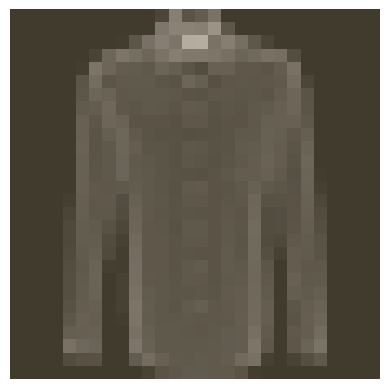

In [5]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 392)
        self.fc2 = nn.Linear(392, 196)
        self.fc3 = nn.Linear(196, 98)
        self.fc4 = nn.Linear(98, 49)
        self.fc5 = nn.Linear(49, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.log_softmax(self.fc5(x), dim=1)
        
        return x

In [7]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the network

In [8]:
# TODO: Train the network here
epochs = 20
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # calculate log loss probabilities 
        log_ps = model(images)
        # calculate loss
        loss = criterion(log_ps, labels)
        
        # zero gradients
        optimizer.zero_grad()
        # calculate gradients - backward pass
        loss.backward()
        # take a step in direction minimizing loss
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss {e}: {running_loss/len(trainloader)}")

Training loss 0: 0.5384415988125273
Training loss 1: 0.3839190116823355
Training loss 2: 0.3439246474949917
Training loss 3: 0.31772769329104344
Training loss 4: 0.3017040576650771
Training loss 5: 0.28089143593174054
Training loss 6: 0.2676321674368656
Training loss 7: 0.25579592109774985
Training loss 8: 0.24555623726740575
Training loss 9: 0.23424088577233526
Training loss 10: 0.22294457409697682
Training loss 11: 0.21408846576823226
Training loss 12: 0.20522117192573003
Training loss 13: 0.1959421976185493
Training loss 14: 0.18750753950700957
Training loss 15: 0.179833336713424
Training loss 16: 0.1749659511270617
Training loss 17: 0.1657480795953129
Training loss 18: 0.1620766037761339
Training loss 19: 0.1529801295184568


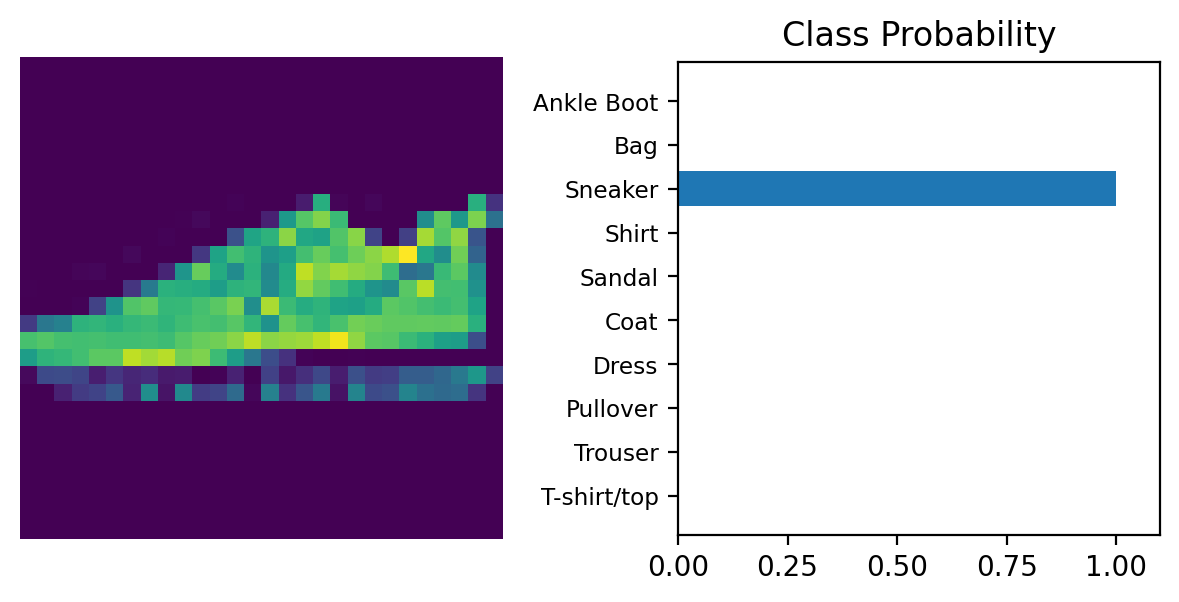

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper

# Test out your network!

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# TODO: Calculate the class probabilities (softmax) for img
ps = torch.exp(model(img))

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps, version='Fashion')

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # type: ignore

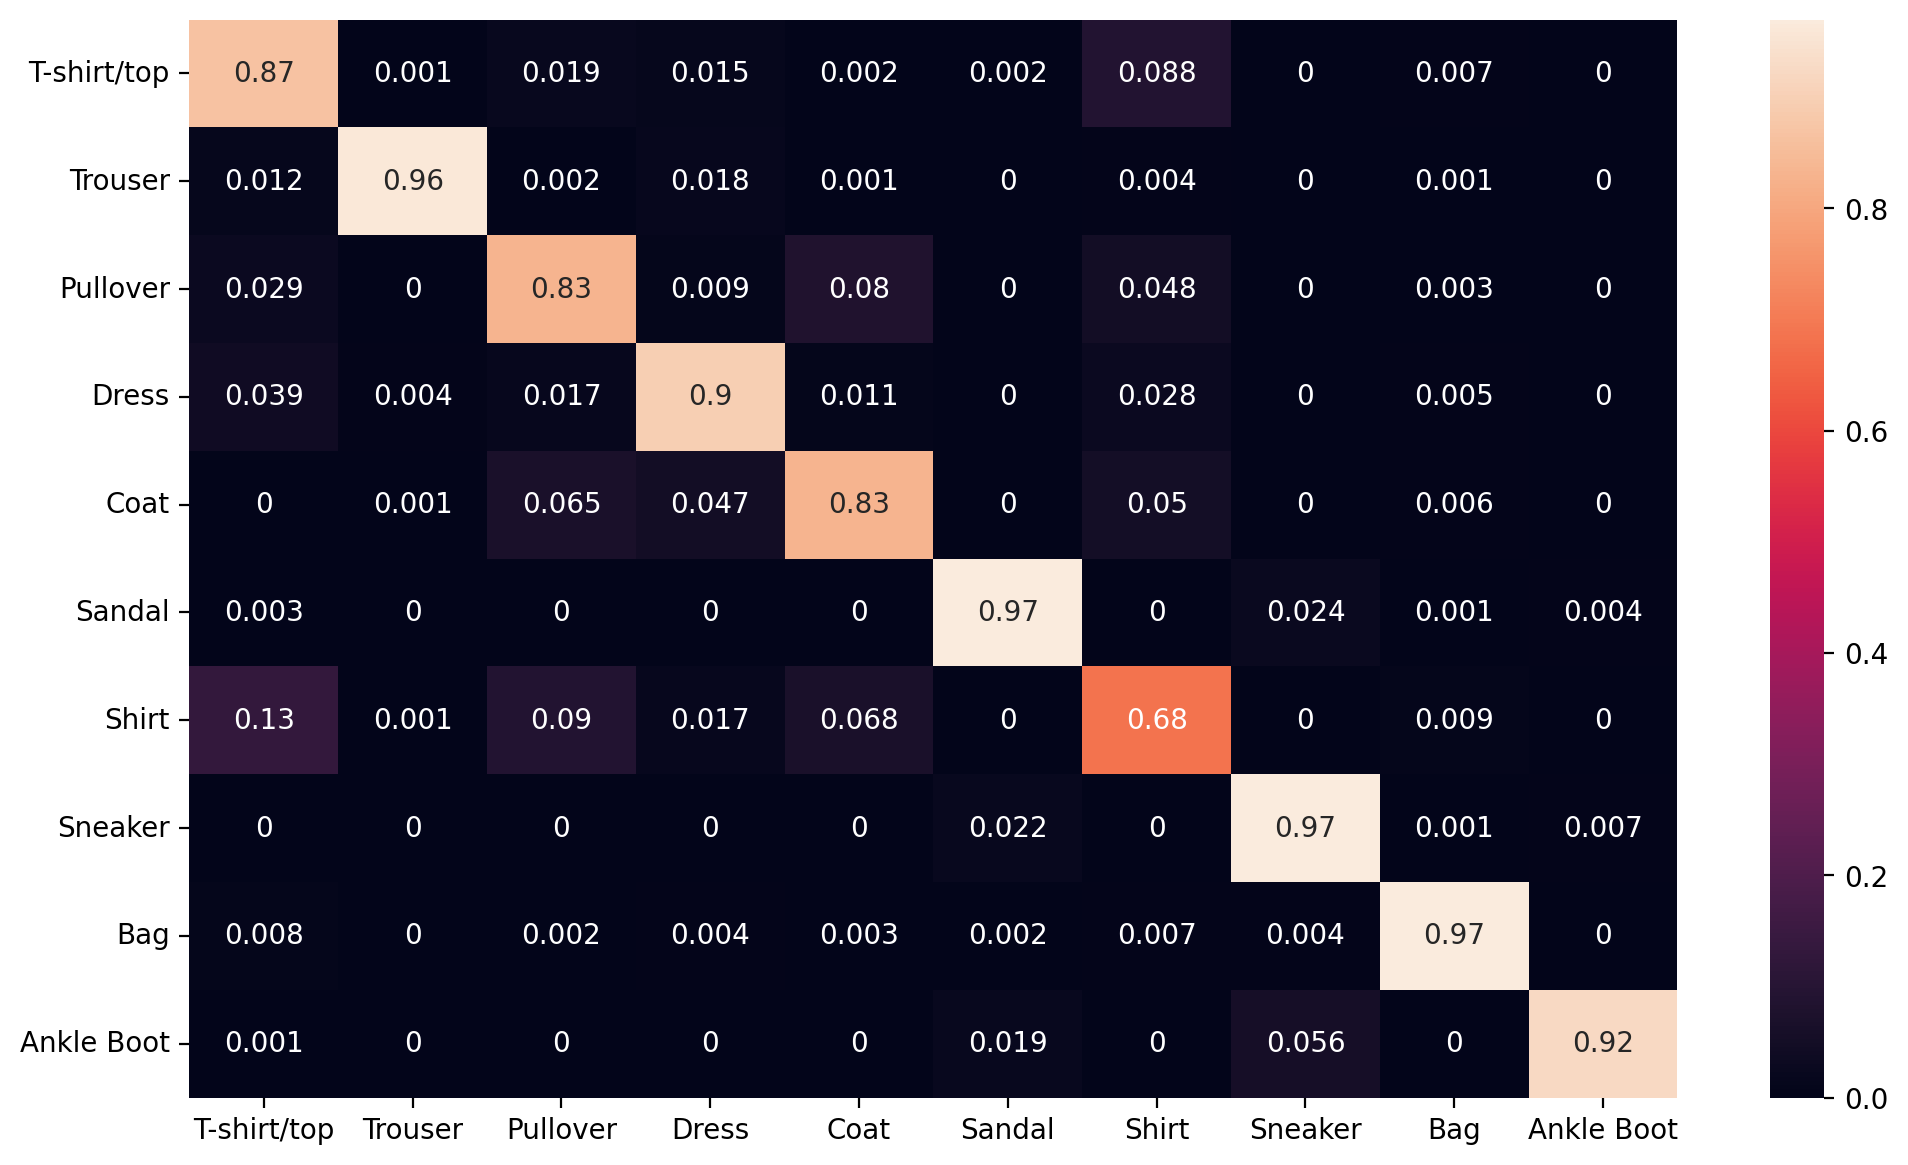

In [14]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        
# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True)
plt.show()

# Inference and Validation

In [24]:
model = Classifier()
criterion = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20

train_losses, test_losses = [], []
for e in range(epochs):
    tot_train_loss = 0
    for images, labels in trainloader:
        
        # calculate log loss probabilities
        log_ps = model(images)
        # calculate loss
        loss = criterion(log_ps, labels)
        tot_train_loss += loss.item()
        
        # zero gradients
        optimizer.zero_grad()        
        # calculate gradients - backward pass
        loss.backward()
        # take a step in direction minimizing loss
        optimizer.step()
    else:
        tot_test_loss = 0
        test_correct = 0  # Initialize number of correct predictions on the test set as 0
        
        # Turn off gradients for validation to save memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                
                # calculate log loss probabilities
                log_ps = model(images)
                # calculate loss
                loss = criterion(log_ps, labels)
                tot_test_loss += loss.item()
            
                # calculate class probabilities
                ps = torch.exp(log_ps)
                # calculate correct predictions
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        # Calculate average loss between train and test sets
        train_loss = tot_train_loss / len(trainloader.dataset)
        test_loss = tot_test_loss / len(testloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

Epoch: 1/20..  Training Loss: 0.543..  Test Loss: 0.428..  Test Accuracy: 0.848
Epoch: 2/20..  Training Loss: 0.388..  Test Loss: 0.416..  Test Accuracy: 0.850
Epoch: 3/20..  Training Loss: 0.343..  Test Loss: 0.385..  Test Accuracy: 0.865
Epoch: 4/20..  Training Loss: 0.317..  Test Loss: 0.383..  Test Accuracy: 0.862
Epoch: 5/20..  Training Loss: 0.294..  Test Loss: 0.350..  Test Accuracy: 0.876
Epoch: 6/20..  Training Loss: 0.279..  Test Loss: 0.345..  Test Accuracy: 0.875
Epoch: 7/20..  Training Loss: 0.267..  Test Loss: 0.358..  Test Accuracy: 0.871
Epoch: 8/20..  Training Loss: 0.252..  Test Loss: 0.348..  Test Accuracy: 0.882
Epoch: 9/20..  Training Loss: 0.241..  Test Loss: 0.360..  Test Accuracy: 0.874
Epoch: 10/20..  Training Loss: 0.229..  Test Loss: 0.339..  Test Accuracy: 0.884
Epoch: 11/20..  Training Loss: 0.219..  Test Loss: 0.326..  Test Accuracy: 0.888
Epoch: 12/20..  Training Loss: 0.212..  Test Loss: 0.360..  Test Accuracy: 0.873
Epoch: 13/20..  Training Loss: 0.202.

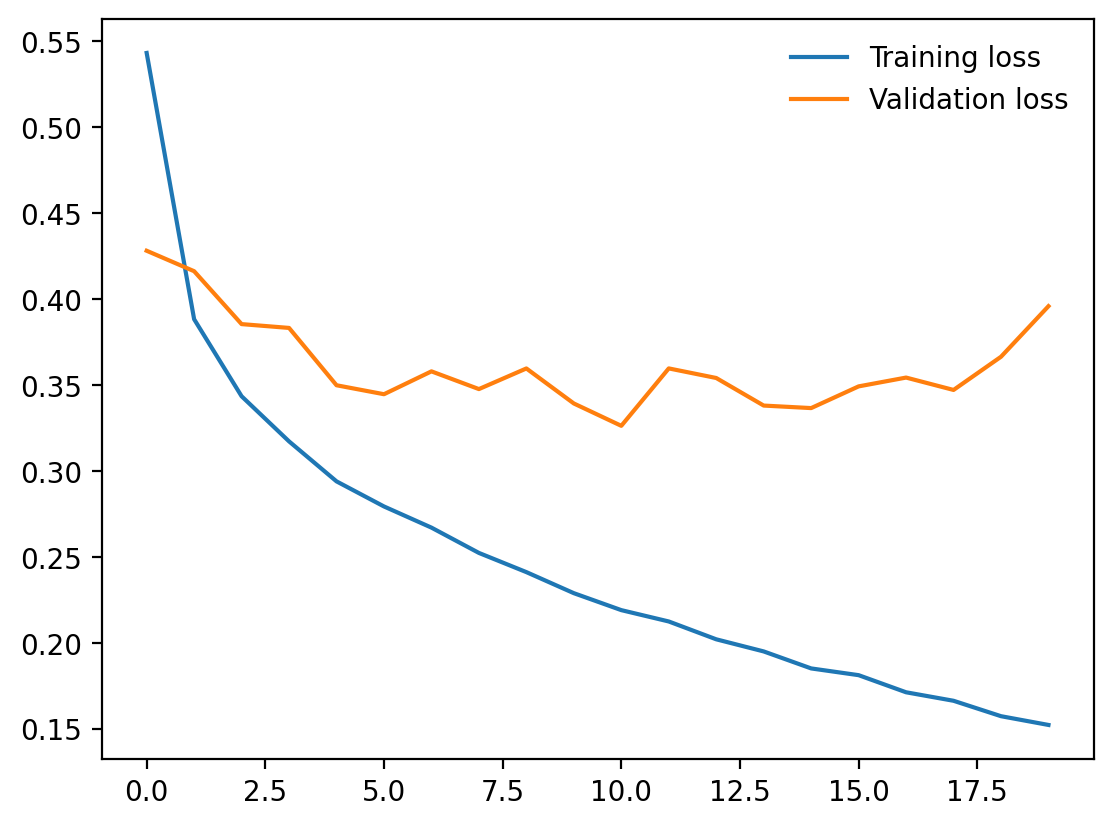

In [26]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

# Overfitting

In [27]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 392)
        self.fc2 = nn.Linear(392, 196)
        self.fc3 = nn.Linear(196, 98)
        self.fc4 = nn.Linear(98, 49)
        self.fc5 = nn.Linear(49, 10)
        
        # Dropout module with 0.40 drop probability
        self.dropout = nn.Dropout(p=0.40)

        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = F.log_softmax(self.fc5(x), dim=1)
        
        return x

In [28]:
model = Classifier()
criterion = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20

train_losses, test_losses = [], []
for e in range(epochs):
    tot_train_loss = 0
    for images, labels in trainloader:
        
        # calculate log loss probabilities
        log_ps = model(images)
        # calculate loss
        loss = criterion(log_ps, labels)
        tot_train_loss += loss.item()
        
        # zero gradients
        optimizer.zero_grad()        
        # calculate gradients - backward pass
        loss.backward()
        # take a step in direction minimizing loss
        optimizer.step()
    else:
        tot_test_loss = 0
        test_correct = 0  # Initialize number of correct predictions on the test set as 0
        
        # Turn off gradients for validation to save memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                
                # calculate log loss probabilities
                log_ps = model(images)
                # calculate loss
                loss = criterion(log_ps, labels)
                tot_test_loss += loss.item()

                # calculate class probabilities
                ps = torch.exp(log_ps)
                # calculate correct predictions
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        # Calculate average loss between train and test sets
        train_loss = tot_train_loss / len(trainloader.dataset)
        test_loss = tot_test_loss / len(testloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

Epoch: 1/20..  Training Loss: 0.807..  Test Loss: 0.645..  Test Accuracy: 0.769
Epoch: 2/20..  Training Loss: 0.573..  Test Loss: 0.562..  Test Accuracy: 0.810
Epoch: 3/20..  Training Loss: 0.514..  Test Loss: 0.526..  Test Accuracy: 0.827
Epoch: 4/20..  Training Loss: 0.488..  Test Loss: 0.521..  Test Accuracy: 0.827
Epoch: 5/20..  Training Loss: 0.465..  Test Loss: 0.487..  Test Accuracy: 0.835
Epoch: 6/20..  Training Loss: 0.447..  Test Loss: 0.492..  Test Accuracy: 0.832
Epoch: 7/20..  Training Loss: 0.442..  Test Loss: 0.486..  Test Accuracy: 0.843
Epoch: 8/20..  Training Loss: 0.425..  Test Loss: 0.483..  Test Accuracy: 0.846
Epoch: 9/20..  Training Loss: 0.421..  Test Loss: 0.475..  Test Accuracy: 0.848
Epoch: 10/20..  Training Loss: 0.411..  Test Loss: 0.475..  Test Accuracy: 0.843
Epoch: 11/20..  Training Loss: 0.405..  Test Loss: 0.450..  Test Accuracy: 0.852
Epoch: 12/20..  Training Loss: 0.399..  Test Loss: 0.483..  Test Accuracy: 0.846
Epoch: 13/20..  Training Loss: 0.397.

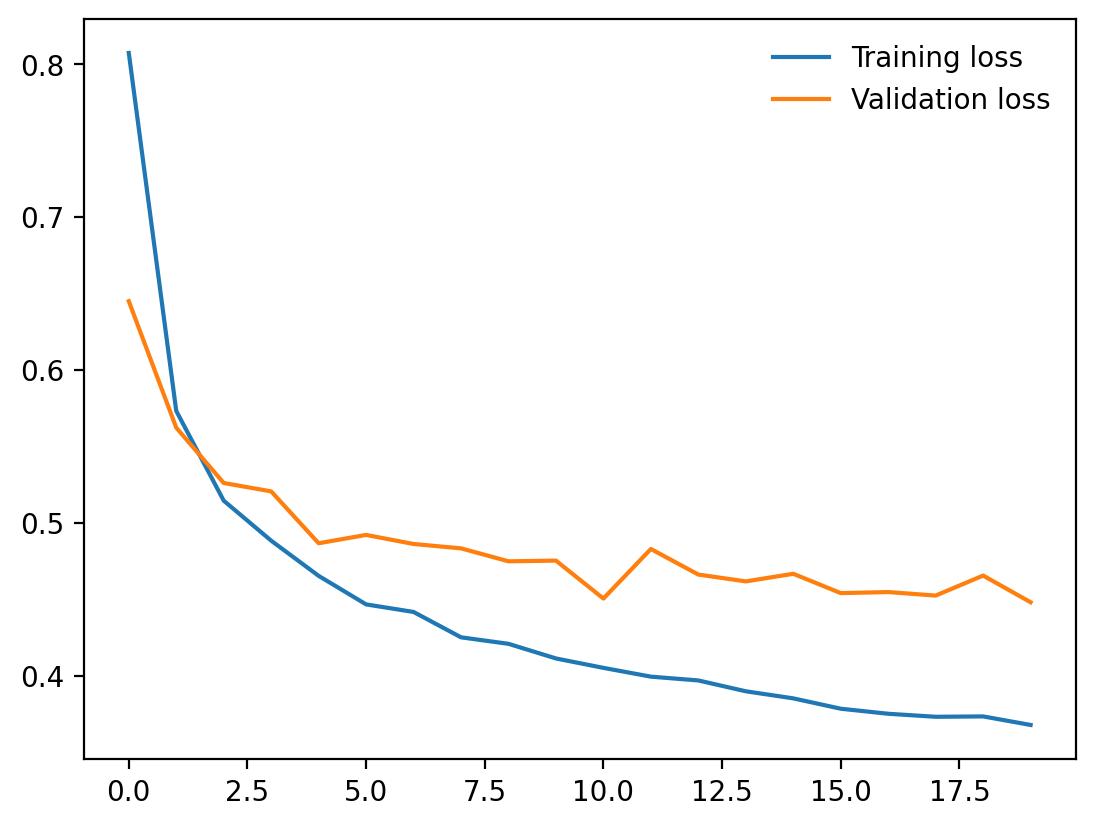

In [29]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

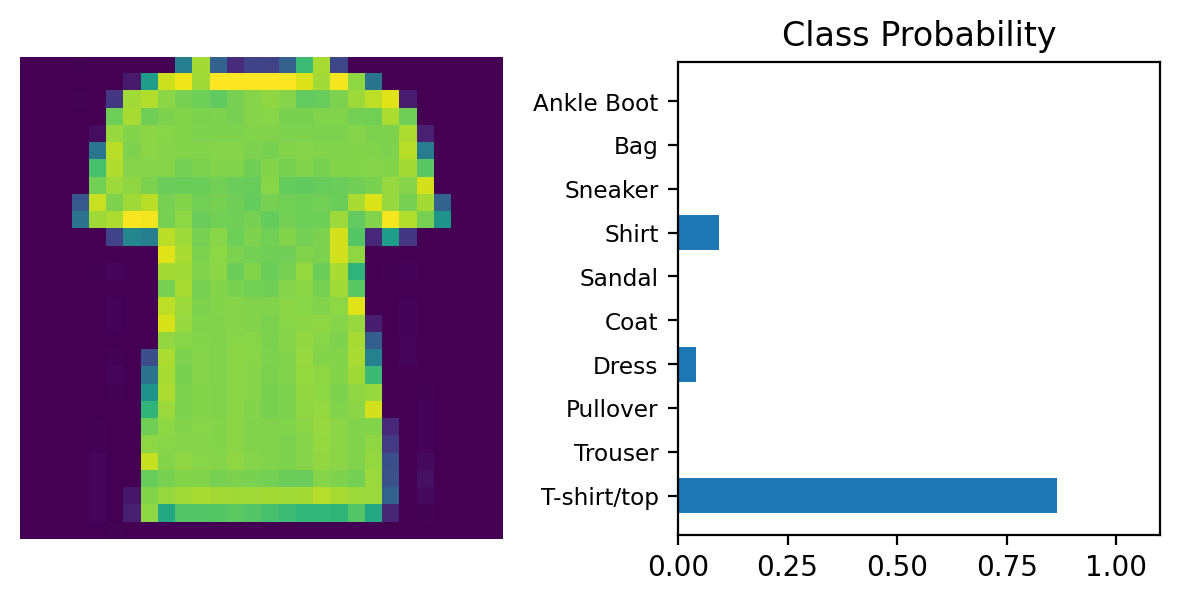

In [49]:
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# TODO: Calculate the class probabilities (softmax) for img
ps = torch.exp(model(img))

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps, version='Fashion')